### 1. Importing your libraries and data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Creating path
path = r'C:\Users\sanch\Documents\CareerFoundry\Achievement 6'

# Import data
data = pd.read_csv(os.path.join(path, '1. Data', 'New_Student_Rolls.csv'))


### 1. Preparing the data

In [3]:
# Convert 'Year' to integer datatype
data['Year'] = data['Year'].astype(int)

data['Year']

0        2010
1        2011
2        2012
3        2013
4        2014
         ... 
37756    2020
37757    2021
37758    2022
37759    2023
37760    2024
Name: Year, Length: 37761, dtype: int64

In [4]:
# Subst the Auckland regional data
data_akl = data.loc[data['Regional Council'] == 'Auckland']

In [5]:
# Create a pivot table for total enrollments in Immersion None
pivot = pd.pivot_table(
    data_akl,
    values='Immersion None',
    index='Year',
    aggfunc='sum'
).reset_index()

pivot

,Year,Immersion None
0,2010,89106
1,2011,89048
2,2012,89050
3,2013,88028
4,2014,88726
5,2015,88786
6,2016,88051
7,2017,87179
8,2018,87123
9,2019,86146


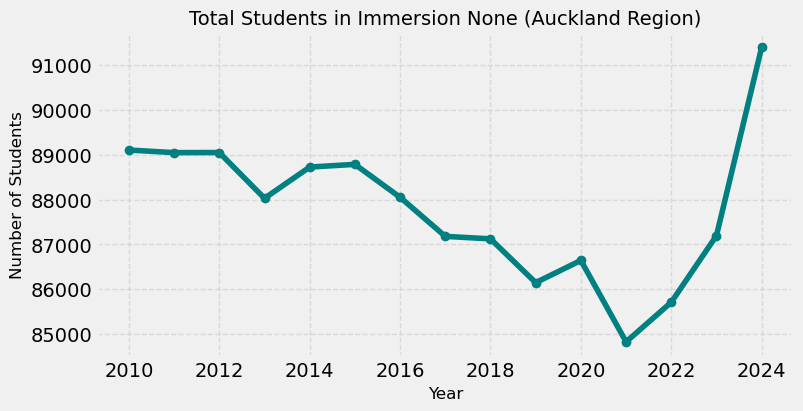

In [6]:
# Plot the data

plt.figure(figsize=(8,4))
plt.plot(pivot['Year'], pivot['Immersion None'], marker='o', color='teal')
plt.title('Total Students in Immersion None (Auckland Region)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(r"C:\Users\sanch\Documents\CareerFoundry\Achievement 6\3. Visualisations\line_akl_none_overall.png")
plt.show()

##### **Observation:** 
The number of Auckland students enrolled in Immersion None programmes began at around 89,000 in 2010 and declined steadily until it reached its lowest point in 2021. Since then, enrolments have risen again, reaching approximately 91,000 in 2024.

In [7]:
# Print the Augmented Dickey–Fuller test statistics
result = adfuller(pivot['Immersion None'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.1641077020047166
p-value: 0.21952913951158953


##### **Observation:** The number of students in “Immersion None” (Auckland Region) is non-stationary (*p* > .05).


---

### 3. Plotting the yearly trends using a Moving Average

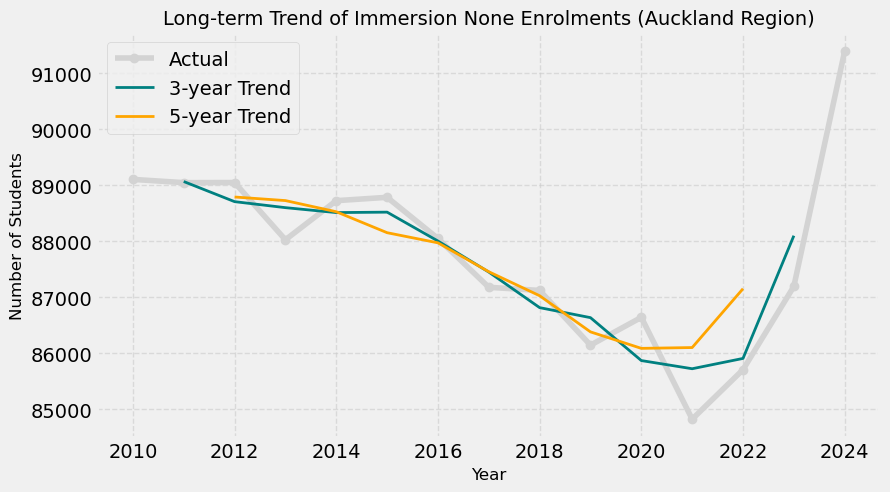

In [8]:
# Sort by year and ensure numeric
pivot = pivot.sort_values('Year')
pivot['Year'] = pivot['Year'].astype(int)

# Apply a 3-year and 5-year moving average
pivot['MA3'] = pivot['Immersion None'].rolling(window=3, center=True).mean()
pivot['MA5'] = pivot['Immersion None'].rolling(window=5, center=True).mean()

# Plot
plt.figure(figsize=(9,5))
plt.plot(pivot['Year'], pivot['Immersion None'], color='lightgray', marker='o', label='Actual')
plt.plot(pivot['Year'], pivot['MA3'], color='teal', linewidth=2, label='3-year Trend')
plt.plot(pivot['Year'], pivot['MA5'], color='orange', linewidth=2, label='5-year Trend')
plt.title('Long-term Trend of Immersion None Enrolments (Auckland Region)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(r"C:\Users\sanch\Documents\CareerFoundry\Achievement 6\3. Visualisations\line_akl_none_moving.png")
plt.show()

##### **Observation:** Student enrollments in Immersion None show an upward trend after 2022. 

### 4. Testing for stationarity

In [9]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(pivot['Immersion None'])

Dickey-Fuller Stationarity test:
Test Statistic                -2.164108
p-value                        0.219529
Number of Lags Used            5.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


##### **Observation:** The number of students in “Immersion None” (Auckland Region) is non-stationary (p > .05).

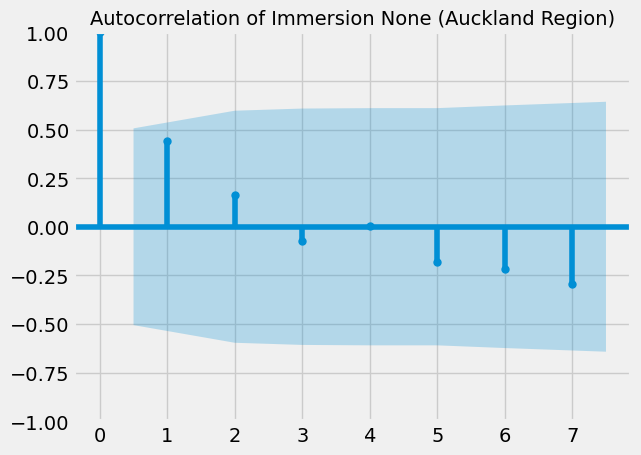

In [10]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(pivot['Immersion None'])
plt.title('Autocorrelation of Immersion None (Auckland Region)', fontsize=14)
plt.savefig(r"C:\Users\sanch\Documents\CareerFoundry\Achievement 6\3. Visualisations\line_akl_none_autocorr.png")
plt.show()

##### **Observation:** 
The number of students in Immersion None programmes in the Auckland Region exhibits autocorrelation, indicating that enrolments in one year are correlated with those in previous years.

### 5. Stationarizing the Student Rolls Data

In [11]:
data_diff = pivot['Immersion None'] - pivot['Immersion None'].shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [12]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [13]:
data_diff.head()

1     -58.0
2       2.0
3   -1022.0
4     698.0
5      60.0
Name: Immersion None, dtype: float64

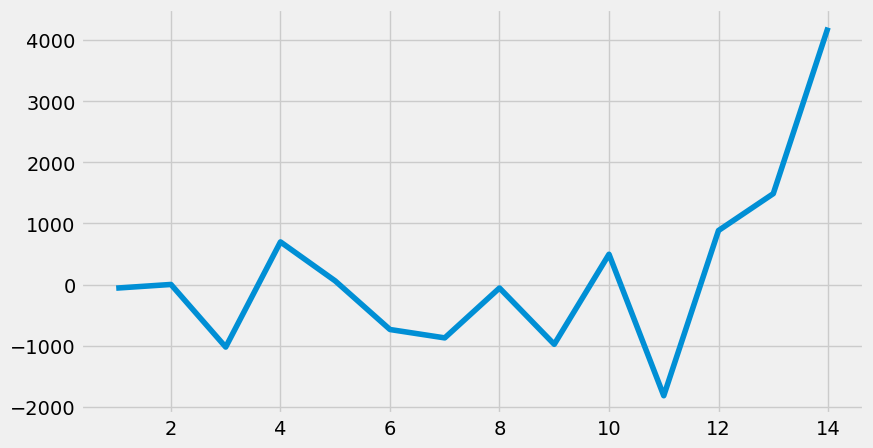

In [14]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(9,5))
plt.plot(data_diff)

In [15]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  0.521550
p-value                         0.985514
Number of Lags Used             1.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


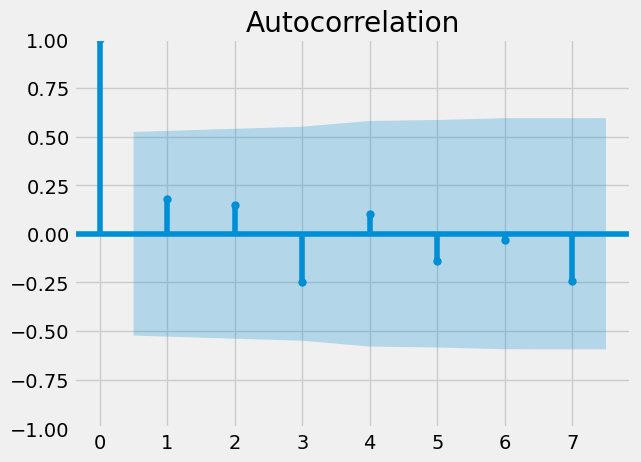

In [16]:
plot_acf(data_diff)
plt.show()

##### **Observation:** 
The persistence of non-stationarity after differencing suggests that enrolment levels in Immersion None programmes follow a slow, long-term structural trend rather than short-term fluctuations, reflecting gradual policy or demographic influences in the Auckland Region.